In [1]:
using JLD2
using FileIO
using LinearAlgebra
using Plots
using Dierckx
using LinearAlgebra
using LaTeXStrings
using Meshfree4ScalarEq.ScalarHyperbolicEquations
using Meshfree4ScalarEq.ParticleGrids
using Meshfree4ScalarEq.TimeIntegration
using Meshfree4ScalarEq.Interpolations
using Meshfree4ScalarEq.SimSettings
using Meshfree4ScalarEq
plotlyjs()

Plots.PlotlyJSBackend()

In [2]:
function mapGrid(x, xmin, xmax)
    temp = x .- xmin
    temp1 = mod.(temp, xmax-xmin)
    return temp1 .+ xmin
end;

function smoothInit(x::Real, y::Real)
    return exp(-x^2 - y^2)
end;

function shockInit(x::Real, y::Real)
    return (-0.5 < x < 0.5) && (-0.5 < y < 0.5) ? 1.0 : 0.0
end;

In [3]:
function computeError(particleGrid::ParticleGrid2D, initFunc::Function, time::Real, vel::Tuple{Float64, Float64}; normP = 2)    
    rhosReduced = collect(map(particle -> particle.rho, particleGrid.grid))
    xsIrregularReduced = collect(map(particle -> particle.pos, particleGrid.grid))
    
    exactSol = zeros(length(xsIrregularReduced))
    for (index, (x, y)) in enumerate(xsIrregularReduced)
        exactSol[index] = initFunc(mapGrid(x - vel[1]*time, particleGrid.xmin, particleGrid.xmax), mapGrid(y - vel[2]*time, particleGrid.ymin, particleGrid.ymax))
    end

    # Return absolute error
    return norm(exactSol - rhosReduced, normP)/norm(exactSol, normP)
end;

In [4]:
folder = "$(@__DIR__)/data/";
a = (1.0, 1.0);
tmax = 1.0;
Algorithms = ["MeshfreeUpwind1" "RK3WENO2" "RK3MOODUpwind2" "RK3MUSCL2" "RK3MOODMUSCL2" "RK3MUSCL1" "NonLinearPraveen"];
labels = ["Upwind: order 1" "WENO: order 2" "Upwind + MOOD: order 2" "MUSCL: order 2" "MUSCL + MOOD: order 2" "MUSCL: order 1" "Nonlinear Upwind Praveen"];

In [5]:
d1 = load(folder*"timingResults_smoothInit.jld2");
d2 = load(folder*"timingResults_shockInit.jld2");

Ns = d1["Ns"];
# algsNumber = d1["Algs"];
# timingsSmooth = reshape(d1["pmapRes"], (length(algsNumber), length(Ns)));
# timingsShock = reshape(d2["pmapRes"], (length(algsNumber), length(Ns)));

6-element Vector{Int64}:
  30
  50
  70
 100
 175
 250

In [6]:
errorsSmooth = zeros((length(Ns), length(Algorithms)))
for file in readdir(folder)
    if isdir(folder*file)
        Alg, _, _, N = split(file, "_")
        N = parse(Float64, N)
        if (N in Ns) && contains(file, "smoothInit") && (Alg in Algorithms)
            algIndex = findfirst(x -> x == Alg, Algorithms)[2]
            NIndex = findfirst(x -> x == N, Ns)
            particleGrid = load(folder*file*"/data/step1.jld2")["particleGrid"]
            errorsSmooth[NIndex, algIndex] = computeError(particleGrid, smoothInit, tmax, a)
        end
    end
end

In [7]:
ms = 3;

┌ Warning: markershape star5 is unsupported with Plots.PlotlyJSBackend(). Choose from: [:auto, :circle, :cross, :diamond, :dtriangle, :hexagon, :hline, :none, :octagon, :pentagon, :rect, :utriangle, :vline, :x, :xcross]
└ @ Plots /users/cip/techno1/cac13ruw/.julia/packages/Plots/ju9dp/src/args.jl:1575
┌ Warning: markershape star5 is unsupported with Plots.PlotlyJSBackend(). Choose from: [:auto, :circle, :cross, :diamond, :dtriangle, :hexagon, :hline, :none, :octagon, :pentagon, :rect, :utriangle, :vline, :x, :xcross]
└ @ Plots /users/cip/techno1/cac13ruw/.julia/packages/Plots/ju9dp/src/args.jl:1575
┌ Warning: attempting to remove probably stale pidfile
│   path = /net/nascip131/users/cip/techno1/cac13ruw/.jlassetregistry.lock
└ @ Pidfile /users/cip/techno1/cac13ruw/.julia/packages/Pidfile/DDu3M/src/Pidfile.jl:260


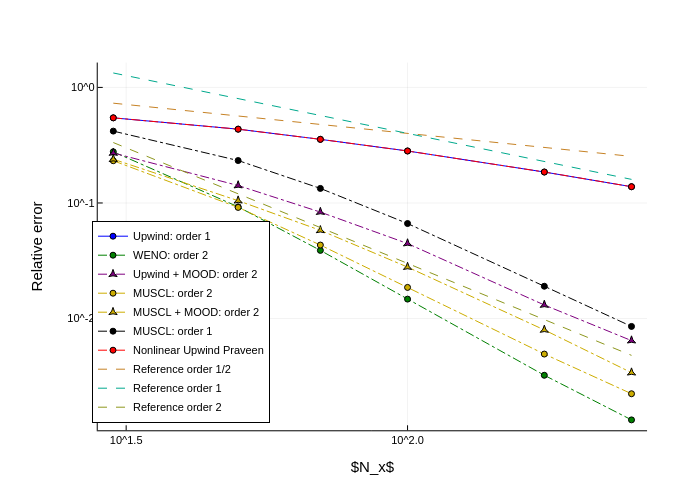

"/scratch/cac13ruw/meshfree4hypeq/numericalExperiments/convergence2D/convergenceSmoothInit.pdf"

In [8]:
p1 = plot(Ns, errorsSmooth[:, 1], xscale=:log10, yscale=:log10, label=labels[1], legend=:bottomleft, ylabel="Relative error", xlabel=L"N_x", ls=:solid, markershape=:circle, markersize=ms, size=(800, 600), c=:blue)
plot!(p1, Ns, errorsSmooth[:, 2], xscale=:log10, yscale=:log10, label=labels[2], ls=:dashdot, markershape=:circle, markersize=ms, c=:green)
plot!(p1, Ns, errorsSmooth[:, 3], xscale=:log10, yscale=:log10, label=labels[3], ls=:dashdot, markershape=:star, markersize=ms, c=:purple)
plot!(p1, Ns, errorsSmooth[:, 4], xscale=:log10, yscale=:log10, label=labels[4], ls=:dashdot, markershape=:circle, markersize=ms, c=:gold3)
plot!(p1, Ns, errorsSmooth[:, 5], xscale=:log10, yscale=:log10, label=labels[5], ls=:dashdot, markershape=:star, markersize=ms, c=:gold3)
plot!(p1, Ns, errorsSmooth[:, 6], xscale=:log10, yscale=:log10, label=labels[6], ls=:dashdot, markershape=:circle, markersize=ms, c=:black)
plot!(p1, Ns, errorsSmooth[:, 7], xscale=:log10, yscale=:log10, label=labels[7], ls=:dashdot, markershape=:circle, markersize=ms, c=:red)
plot!(p1, Ns, 4 ./ (Ns.^0.5), label="Reference order 1/2", ls=:dash)
plot!(p1, Ns, 40 ./ Ns, label="Reference order 1", ls=:dash)
plot!(p1, Ns, 300 ./ (Ns.^2), label="Reference order 2", ls=:dash)
display(p1)
savefig(p1, "$(@__DIR__)/convergenceSmoothInit.pdf")

In [9]:
errorsShock = zeros((length(Ns), length(Algorithms)))
for file in readdir(folder)
    if isdir(folder*file)
        Alg, _, _, N = split(file, "_")
        N = parse(Float64, N)
        if (N in Ns) && contains(file, "shockInit") && (Alg in Algorithms)
            algIndex = findfirst(x -> x == Alg, Algorithms)[2]
            NIndex = findfirst(x -> x == N, Ns)
            particleGrid = load(folder*file*"/data/step1.jld2")["particleGrid"]
            errorsShock[NIndex, algIndex] = computeError(particleGrid, shockInit, tmax, a)
        end
    end
end

┌ Warning: markershape star5 is unsupported with Plots.PlotlyJSBackend(). Choose from: [:auto, :circle, :cross, :diamond, :dtriangle, :hexagon, :hline, :none, :octagon, :pentagon, :rect, :utriangle, :vline, :x, :xcross]
└ @ Plots /users/cip/techno1/cac13ruw/.julia/packages/Plots/ju9dp/src/args.jl:1575
┌ Warning: markershape star5 is unsupported with Plots.PlotlyJSBackend(). Choose from: [:auto, :circle, :cross, :diamond, :dtriangle, :hexagon, :hline, :none, :octagon, :pentagon, :rect, :utriangle, :vline, :x, :xcross]
└ @ Plots /users/cip/techno1/cac13ruw/.julia/packages/Plots/ju9dp/src/args.jl:1575


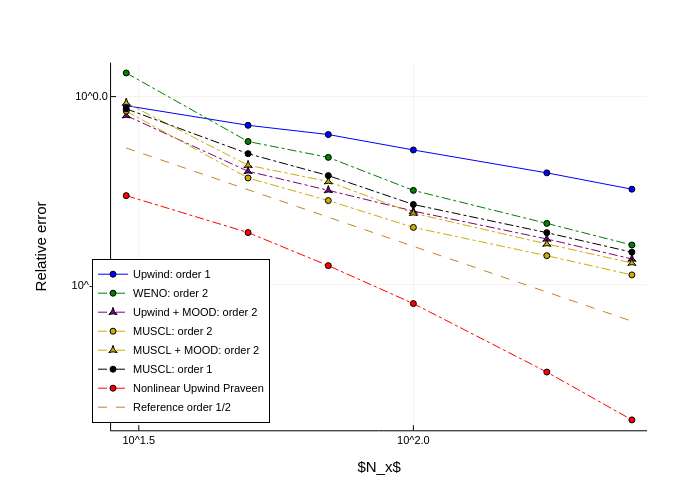

"/scratch/cac13ruw/meshfree4hypeq/numericalExperiments/convergence2D/convergenceShock.pdf"

In [16]:
p2 = plot(Ns, errorsShock[:, 1], xscale=:log10, yscale=:log10, label=labels[1], legend=:bottomleft, ylabel="Relative error", xlabel=L"N_x", ls=:solid, markershape=:circle, markersize=ms, size=(800, 600), c=:blue)
plot!(p2, Ns, errorsShock[:, 2], xscale=:log10, yscale=:log10, label=labels[2], ls=:dashdot, markershape=:circle, markersize=ms, c=:green)
plot!(p2, Ns, errorsShock[:, 3], xscale=:log10, yscale=:log10, label=labels[3], ls=:dashdot, markershape=:star, markersize=ms, c=:purple)
plot!(p2, Ns, errorsShock[:, 4], xscale=:log10, yscale=:log10, label=labels[4], ls=:dashdot, markershape=:circle, markersize=ms, c=:gold3)
plot!(p2, Ns, errorsShock[:, 5], xscale=:log10, yscale=:log10, label=labels[5], ls=:dashdot, markershape=:star, markersize=ms, c=:gold3)
plot!(p2, Ns, errorsShock[:, 6], xscale=:log10, yscale=:log10, label=labels[6], ls=:dashdot, markershape=:circle, markersize=ms, c=:black)
plot!(p2, Ns, errorsSmooth[:, 7], xscale=:log10, yscale=:log10, label=labels[7], ls=:dashdot, markershape=:circle, markersize=ms, c=:red)
plot!(p2, Ns, 4 ./ (Ns.^0.5), label="Reference order 1/2", ls=:dash)
# plot!(p2, Ns, 40 ./ Ns, label="Reference order 1", ls=:dash)
display(p2)
savefig(p2, "$(@__DIR__)/convergenceShock.pdf")

In [15]:
size(errorsSmooth)

(6, 7)